In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, ZeroPadding2D

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


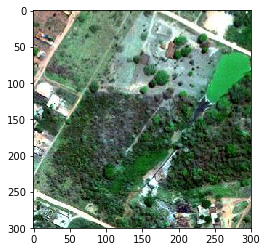

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"


model_name = "DenseNet-161"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00032
batch_size = 20
num_epochs = 1200
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))
    x = ZeroPadding2D(padding=(3, 3))(input)
    x = Conv2D(2*k, 7, strides=2, padding="valid", name="conv2d_1", use_bias=False)(x)
    x = BatchNormalization(name= "batch_normalization_input")(x)
    x = ReLU()(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPool2D(3, strides=2, padding="valid")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_input (Batc (None, 112, 112, 96) 384         conv2d_1[0][0]                   
___________

Total params: 26,820,062
Trainable params: 26,604,542
Non-trainable params: 215,520
__________________________________________________________________________________________________


In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

Epoch 1/1200
4/4 [==============================] - 72s 18s/step - loss: 4.1363 - categorical_accuracy: 0.0000e+00 - val_loss: 4.1448 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1200
4/4 [==============================] - 11s 3s/step - loss: 4.1306 - categorical_accuracy: 0.0597 - val_loss: 4.1469 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1200
4/4 [==============================] - 7s 2s/step - loss: 4.1520 - categorical_accuracy: 0.0125 - val_loss: 4.1560 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1200
4/4 [==============================] - 7s 2s/step - loss: 4.1469 - categorical_accuracy: 0.0125 - val_loss: 4.1635 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1200
4/4 [==============================] - 7s 2s/step - loss: 4.1334 - categorical_accuracy: 0.0125 - val_loss: 4.1624 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1200
4/4 [==============================] - 7s 2s/step - loss: 4.1338 - categorical_accuracy: 0.0125 - val_loss: 4.1592 - val_categorical_accuracy: 0.

Epoch 23/1200
4/4 [==============================] - 7s 2s/step - loss: 3.7974 - categorical_accuracy: 0.0500 - val_loss: 9.8789 - val_categorical_accuracy: 0.0500
Epoch 24/1200
4/4 [==============================] - 7s 2s/step - loss: 3.8686 - categorical_accuracy: 0.0000e+00 - val_loss: 9.9922 - val_categorical_accuracy: 0.0625
Epoch 25/1200
4/4 [==============================] - 7s 2s/step - loss: 3.6680 - categorical_accuracy: 0.1000 - val_loss: 11.8517 - val_categorical_accuracy: 0.0750
Epoch 26/1200
4/4 [==============================] - 7s 2s/step - loss: 3.8508 - categorical_accuracy: 0.0500 - val_loss: 13.8576 - val_categorical_accuracy: 0.0500
Epoch 27/1200
4/4 [==============================] - 7s 2s/step - loss: 3.8364 - categorical_accuracy: 0.0125 - val_loss: 7.9373 - val_categorical_accuracy: 0.0250
Epoch 28/1200
4/4 [==============================] - 7s 2s/step - loss: 3.6940 - categorical_accuracy: 0.1375 - val_loss: 5.2484 - val_categorical_accuracy: 0.0625
Epoch 29/1

4/4 [==============================] - 7s 2s/step - loss: 3.6514 - categorical_accuracy: 0.0250 - val_loss: 5.6578 - val_categorical_accuracy: 0.0375
Epoch 46/1200
4/4 [==============================] - 7s 2s/step - loss: 3.6496 - categorical_accuracy: 0.0750 - val_loss: 4.6876 - val_categorical_accuracy: 0.0250
Epoch 47/1200
4/4 [==============================] - 6s 1s/step - loss: 3.5782 - categorical_accuracy: 0.0896 - val_loss: 4.5781 - val_categorical_accuracy: 0.0250
Epoch 48/1200
4/4 [==============================] - 7s 2s/step - loss: 3.4163 - categorical_accuracy: 0.1000 - val_loss: 4.6110 - val_categorical_accuracy: 0.0375
Epoch 49/1200
4/4 [==============================] - 7s 2s/step - loss: 3.5257 - categorical_accuracy: 0.0750 - val_loss: 4.5950 - val_categorical_accuracy: 0.0750
Epoch 50/1200
4/4 [==============================] - 7s 2s/step - loss: 3.5108 - categorical_accuracy: 0.0750 - val_loss: 4.9406 - val_categorical_accuracy: 0.0375
Epoch 51/1200
4/4 [===========

4/4 [==============================] - 7s 2s/step - loss: 3.3989 - categorical_accuracy: 0.1250 - val_loss: 11.2787 - val_categorical_accuracy: 0.0375
Epoch 68/1200
4/4 [==============================] - 7s 2s/step - loss: 3.3585 - categorical_accuracy: 0.1000 - val_loss: 11.8622 - val_categorical_accuracy: 0.0250
Epoch 69/1200
4/4 [==============================] - 7s 2s/step - loss: 3.4418 - categorical_accuracy: 0.1125 - val_loss: 11.6346 - val_categorical_accuracy: 0.0375
Epoch 70/1200
4/4 [==============================] - 7s 2s/step - loss: 3.4563 - categorical_accuracy: 0.1000 - val_loss: 10.2191 - val_categorical_accuracy: 0.0375
Epoch 71/1200
4/4 [==============================] - 7s 2s/step - loss: 3.3334 - categorical_accuracy: 0.1125 - val_loss: 9.5469 - val_categorical_accuracy: 0.0375
Epoch 72/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1703 - categorical_accuracy: 0.1750 - val_loss: 7.9393 - val_categorical_accuracy: 0.0375
Epoch 73/1200
4/4 [=======

4/4 [==============================] - 7s 2s/step - loss: 3.3809 - categorical_accuracy: 0.1000 - val_loss: 4.2438 - val_categorical_accuracy: 0.0750
Epoch 90/1200
4/4 [==============================] - 7s 2s/step - loss: 3.3412 - categorical_accuracy: 0.0875 - val_loss: 4.3451 - val_categorical_accuracy: 0.0500
Epoch 91/1200
4/4 [==============================] - 7s 2s/step - loss: 3.2710 - categorical_accuracy: 0.1125 - val_loss: 4.3664 - val_categorical_accuracy: 0.0750
Epoch 92/1200
4/4 [==============================] - 7s 2s/step - loss: 3.2274 - categorical_accuracy: 0.2000 - val_loss: 4.3258 - val_categorical_accuracy: 0.1375
Epoch 93/1200
4/4 [==============================] - 7s 2s/step - loss: 3.3261 - categorical_accuracy: 0.1875 - val_loss: 4.4570 - val_categorical_accuracy: 0.1375
Epoch 94/1200
4/4 [==============================] - 7s 2s/step - loss: 3.2185 - categorical_accuracy: 0.1500 - val_loss: 5.0752 - val_categorical_accuracy: 0.1125
Epoch 95/1200
4/4 [===========

4/4 [==============================] - 6s 1s/step - loss: 2.9102 - categorical_accuracy: 0.1642 - val_loss: 8.3241 - val_categorical_accuracy: 0.0875
Epoch 112/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1482 - categorical_accuracy: 0.1125 - val_loss: 9.9411 - val_categorical_accuracy: 0.0625
Epoch 113/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1151 - categorical_accuracy: 0.1750 - val_loss: 10.9000 - val_categorical_accuracy: 0.0750
Epoch 114/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1988 - categorical_accuracy: 0.1625 - val_loss: 12.1937 - val_categorical_accuracy: 0.0375
Epoch 115/1200
4/4 [==============================] - 7s 2s/step - loss: 3.2076 - categorical_accuracy: 0.1500 - val_loss: 12.6974 - val_categorical_accuracy: 0.0500
Epoch 116/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1588 - categorical_accuracy: 0.1250 - val_loss: 12.0582 - val_categorical_accuracy: 0.0750
Epoch 117/1200
4/4 [=

4/4 [==============================] - 7s 2s/step - loss: 2.9753 - categorical_accuracy: 0.1750 - val_loss: 4.3270 - val_categorical_accuracy: 0.0875
Epoch 134/1200
4/4 [==============================] - 7s 2s/step - loss: 3.0199 - categorical_accuracy: 0.1375 - val_loss: 4.6256 - val_categorical_accuracy: 0.0625
Epoch 135/1200
4/4 [==============================] - 7s 2s/step - loss: 3.0078 - categorical_accuracy: 0.2000 - val_loss: 4.9479 - val_categorical_accuracy: 0.0625
Epoch 136/1200
4/4 [==============================] - 7s 2s/step - loss: 2.9389 - categorical_accuracy: 0.1875 - val_loss: 5.5411 - val_categorical_accuracy: 0.0875
Epoch 137/1200
4/4 [==============================] - 7s 2s/step - loss: 3.0915 - categorical_accuracy: 0.1750 - val_loss: 9.2762 - val_categorical_accuracy: 0.0625
Epoch 138/1200
4/4 [==============================] - 7s 2s/step - loss: 3.2324 - categorical_accuracy: 0.1250 - val_loss: 8.8793 - val_categorical_accuracy: 0.0750
Epoch 139/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.7599 - categorical_accuracy: 0.2250 - val_loss: 4.6592 - val_categorical_accuracy: 0.0875
Epoch 156/1200
4/4 [==============================] - 7s 2s/step - loss: 3.1112 - categorical_accuracy: 0.1500 - val_loss: 4.5251 - val_categorical_accuracy: 0.1125
Epoch 157/1200
4/4 [==============================] - 7s 2s/step - loss: 2.8411 - categorical_accuracy: 0.2625 - val_loss: 4.6645 - val_categorical_accuracy: 0.1250
Epoch 158/1200
4/4 [==============================] - 7s 2s/step - loss: 2.9067 - categorical_accuracy: 0.2375 - val_loss: 4.6681 - val_categorical_accuracy: 0.1500
Epoch 159/1200
4/4 [==============================] - 7s 2s/step - loss: 2.7342 - categorical_accuracy: 0.2625 - val_loss: 4.7439 - val_categorical_accuracy: 0.1500
Epoch 160/1200
4/4 [==============================] - 7s 2s/step - loss: 2.7504 - categorical_accuracy: 0.2625 - val_loss: 5.1994 - val_categorical_accuracy: 0.1125
Epoch 161/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.6485 - categorical_accuracy: 0.2500 - val_loss: 4.7591 - val_categorical_accuracy: 0.1125
Epoch 178/1200
4/4 [==============================] - 7s 2s/step - loss: 2.9124 - categorical_accuracy: 0.1750 - val_loss: 4.5684 - val_categorical_accuracy: 0.1250
Epoch 179/1200
4/4 [==============================] - 7s 2s/step - loss: 2.6390 - categorical_accuracy: 0.3000 - val_loss: 4.8483 - val_categorical_accuracy: 0.1000
Epoch 180/1200
4/4 [==============================] - 7s 2s/step - loss: 2.5741 - categorical_accuracy: 0.3125 - val_loss: 5.1124 - val_categorical_accuracy: 0.1375
Epoch 181/1200
4/4 [==============================] - 7s 2s/step - loss: 2.5643 - categorical_accuracy: 0.2625 - val_loss: 5.8478 - val_categorical_accuracy: 0.1375
Epoch 182/1200
4/4 [==============================] - 7s 2s/step - loss: 2.5985 - categorical_accuracy: 0.2750 - val_loss: 6.1864 - val_categorical_accuracy: 0.1250
Epoch 183/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.9461 - categorical_accuracy: 0.1875 - val_loss: 11.6930 - val_categorical_accuracy: 0.0375
Epoch 200/1200
4/4 [==============================] - 7s 2s/step - loss: 2.8816 - categorical_accuracy: 0.2125 - val_loss: 11.8095 - val_categorical_accuracy: 0.0500
Epoch 201/1200
4/4 [==============================] - 6s 1s/step - loss: 2.5255 - categorical_accuracy: 0.3284 - val_loss: 11.0156 - val_categorical_accuracy: 0.0500
Epoch 202/1200
4/4 [==============================] - 7s 2s/step - loss: 2.7089 - categorical_accuracy: 0.2625 - val_loss: 7.2470 - val_categorical_accuracy: 0.0875
Epoch 203/1200
4/4 [==============================] - 7s 2s/step - loss: 2.6636 - categorical_accuracy: 0.2250 - val_loss: 5.2957 - val_categorical_accuracy: 0.1125
Epoch 204/1200
4/4 [==============================] - 7s 2s/step - loss: 2.5621 - categorical_accuracy: 0.3375 - val_loss: 5.3034 - val_categorical_accuracy: 0.1125
Epoch 205/1200
4/4 [==

4/4 [==============================] - 7s 2s/step - loss: 2.7274 - categorical_accuracy: 0.3000 - val_loss: 5.5234 - val_categorical_accuracy: 0.0750
Epoch 222/1200
4/4 [==============================] - 7s 2s/step - loss: 2.8070 - categorical_accuracy: 0.2500 - val_loss: 5.9085 - val_categorical_accuracy: 0.0625
Epoch 223/1200
4/4 [==============================] - 7s 2s/step - loss: 2.5401 - categorical_accuracy: 0.3375 - val_loss: 6.8251 - val_categorical_accuracy: 0.0625
Epoch 224/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4335 - categorical_accuracy: 0.3125 - val_loss: 5.7426 - val_categorical_accuracy: 0.1125
Epoch 225/1200
4/4 [==============================] - 7s 2s/step - loss: 2.7398 - categorical_accuracy: 0.2250 - val_loss: 5.5015 - val_categorical_accuracy: 0.0875
Epoch 226/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4685 - categorical_accuracy: 0.3750 - val_loss: 5.9768 - val_categorical_accuracy: 0.0875
Epoch 227/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.5706 - categorical_accuracy: 0.3375 - val_loss: 6.1752 - val_categorical_accuracy: 0.1125
Epoch 244/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4615 - categorical_accuracy: 0.3125 - val_loss: 5.8371 - val_categorical_accuracy: 0.1125
Epoch 245/1200
4/4 [==============================] - 6s 1s/step - loss: 2.6747 - categorical_accuracy: 0.2537 - val_loss: 4.7840 - val_categorical_accuracy: 0.1250
Epoch 246/1200
4/4 [==============================] - 7s 2s/step - loss: 2.3767 - categorical_accuracy: 0.3750 - val_loss: 5.2697 - val_categorical_accuracy: 0.1250
Epoch 247/1200
4/4 [==============================] - 7s 2s/step - loss: 2.7284 - categorical_accuracy: 0.2875 - val_loss: 5.6564 - val_categorical_accuracy: 0.1375
Epoch 248/1200
4/4 [==============================] - 7s 2s/step - loss: 2.2050 - categorical_accuracy: 0.4000 - val_loss: 5.2705 - val_categorical_accuracy: 0.1000
Epoch 249/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.1963 - categorical_accuracy: 0.3750 - val_loss: 6.1916 - val_categorical_accuracy: 0.0625
Epoch 266/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4671 - categorical_accuracy: 0.3000 - val_loss: 5.7524 - val_categorical_accuracy: 0.0875
Epoch 267/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4629 - categorical_accuracy: 0.3250 - val_loss: 5.4833 - val_categorical_accuracy: 0.1125
Epoch 268/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4933 - categorical_accuracy: 0.3125 - val_loss: 5.0706 - val_categorical_accuracy: 0.1375
Epoch 269/1200
4/4 [==============================] - 6s 1s/step - loss: 2.2042 - categorical_accuracy: 0.3881 - val_loss: 5.1114 - val_categorical_accuracy: 0.1375
Epoch 270/1200
4/4 [==============================] - 7s 2s/step - loss: 2.3182 - categorical_accuracy: 0.2875 - val_loss: 5.3519 - val_categorical_accuracy: 0.1375
Epoch 271/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.1826 - categorical_accuracy: 0.3500 - val_loss: 5.4866 - val_categorical_accuracy: 0.1625
Epoch 288/1200
4/4 [==============================] - 7s 2s/step - loss: 2.3581 - categorical_accuracy: 0.3625 - val_loss: 6.1370 - val_categorical_accuracy: 0.1000
Epoch 289/1200
4/4 [==============================] - 7s 2s/step - loss: 2.2789 - categorical_accuracy: 0.4000 - val_loss: 7.1892 - val_categorical_accuracy: 0.0875
Epoch 290/1200
4/4 [==============================] - 6s 1s/step - loss: 2.5945 - categorical_accuracy: 0.3433 - val_loss: 6.9172 - val_categorical_accuracy: 0.0875
Epoch 291/1200
4/4 [==============================] - 7s 2s/step - loss: 2.2919 - categorical_accuracy: 0.3250 - val_loss: 6.1281 - val_categorical_accuracy: 0.1000
Epoch 292/1200
4/4 [==============================] - 7s 2s/step - loss: 2.4270 - categorical_accuracy: 0.3375 - val_loss: 7.1742 - val_categorical_accuracy: 0.0875
Epoch 293/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 2.1825 - categorical_accuracy: 0.4000 - val_loss: 8.0993 - val_categorical_accuracy: 0.1000
Epoch 310/1200
4/4 [==============================] - 7s 2s/step - loss: 2.0848 - categorical_accuracy: 0.4000 - val_loss: 9.2781 - val_categorical_accuracy: 0.0875
Epoch 311/1200
4/4 [==============================] - 7s 2s/step - loss: 2.1319 - categorical_accuracy: 0.3750 - val_loss: 9.4762 - val_categorical_accuracy: 0.1000
Epoch 312/1200
4/4 [==============================] - 7s 2s/step - loss: 2.0609 - categorical_accuracy: 0.3250 - val_loss: 6.5402 - val_categorical_accuracy: 0.1375
Epoch 313/1200
4/4 [==============================] - 7s 2s/step - loss: 2.3928 - categorical_accuracy: 0.3000 - val_loss: 6.4303 - val_categorical_accuracy: 0.1250
Epoch 314/1200
4/4 [==============================] - 7s 2s/step - loss: 2.0383 - categorical_accuracy: 0.4375 - val_loss: 6.6765 - val_categorical_accuracy: 0.1000
Epoch 315/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.5467 - categorical_accuracy: 0.5875 - val_loss: 6.5382 - val_categorical_accuracy: 0.0750
Epoch 332/1200
4/4 [==============================] - 6s 1s/step - loss: 1.8897 - categorical_accuracy: 0.4627 - val_loss: 6.7765 - val_categorical_accuracy: 0.0875
Epoch 333/1200
4/4 [==============================] - 7s 2s/step - loss: 1.9785 - categorical_accuracy: 0.3875 - val_loss: 6.5141 - val_categorical_accuracy: 0.0625
Epoch 334/1200
4/4 [==============================] - 7s 2s/step - loss: 1.9326 - categorical_accuracy: 0.5125 - val_loss: 6.9249 - val_categorical_accuracy: 0.0500
Epoch 335/1200
4/4 [==============================] - 7s 2s/step - loss: 2.0349 - categorical_accuracy: 0.3875 - val_loss: 6.8619 - val_categorical_accuracy: 0.0750
Epoch 336/1200
4/4 [==============================] - 7s 2s/step - loss: 1.9474 - categorical_accuracy: 0.4500 - val_loss: 7.8657 - val_categorical_accuracy: 0.0875
Epoch 337/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.7118 - categorical_accuracy: 0.4875 - val_loss: 7.8579 - val_categorical_accuracy: 0.0875
Epoch 354/1200
4/4 [==============================] - 7s 2s/step - loss: 1.7644 - categorical_accuracy: 0.4875 - val_loss: 7.2714 - val_categorical_accuracy: 0.0750
Epoch 355/1200
4/4 [==============================] - 7s 2s/step - loss: 1.8134 - categorical_accuracy: 0.4750 - val_loss: 7.3075 - val_categorical_accuracy: 0.0750
Epoch 356/1200
4/4 [==============================] - 6s 1s/step - loss: 2.1074 - categorical_accuracy: 0.3731 - val_loss: 7.3689 - val_categorical_accuracy: 0.0875
Epoch 357/1200
4/4 [==============================] - 7s 2s/step - loss: 1.6602 - categorical_accuracy: 0.5750 - val_loss: 10.5083 - val_categorical_accuracy: 0.0750
Epoch 358/1200
4/4 [==============================] - 7s 2s/step - loss: 1.6841 - categorical_accuracy: 0.4625 - val_loss: 11.3700 - val_categorical_accuracy: 0.0625
Epoch 359/1200
4/4 [===

4/4 [==============================] - 7s 2s/step - loss: 2.1430 - categorical_accuracy: 0.4250 - val_loss: 13.4653 - val_categorical_accuracy: 0.0625
Epoch 376/1200
4/4 [==============================] - 7s 2s/step - loss: 1.8474 - categorical_accuracy: 0.5250 - val_loss: 11.9654 - val_categorical_accuracy: 0.0500
Epoch 377/1200
4/4 [==============================] - 7s 2s/step - loss: 1.6520 - categorical_accuracy: 0.5125 - val_loss: 9.1327 - val_categorical_accuracy: 0.0875
Epoch 378/1200
4/4 [==============================] - 7s 2s/step - loss: 1.6719 - categorical_accuracy: 0.5750 - val_loss: 8.4126 - val_categorical_accuracy: 0.0625
Epoch 379/1200
4/4 [==============================] - 7s 2s/step - loss: 1.8361 - categorical_accuracy: 0.4750 - val_loss: 7.5179 - val_categorical_accuracy: 0.1000
Epoch 380/1200
4/4 [==============================] - 7s 2s/step - loss: 1.7270 - categorical_accuracy: 0.4500 - val_loss: 7.0784 - val_categorical_accuracy: 0.1000
Epoch 381/1200
4/4 [===

4/4 [==============================] - 6s 1s/step - loss: 1.9997 - categorical_accuracy: 0.4179 - val_loss: 7.7466 - val_categorical_accuracy: 0.1000
Epoch 398/1200
4/4 [==============================] - 7s 2s/step - loss: 1.7668 - categorical_accuracy: 0.4875 - val_loss: 7.3730 - val_categorical_accuracy: 0.0875
Epoch 399/1200
4/4 [==============================] - 7s 2s/step - loss: 1.7131 - categorical_accuracy: 0.5375 - val_loss: 7.8169 - val_categorical_accuracy: 0.0875
Epoch 400/1200
4/4 [==============================] - 7s 2s/step - loss: 1.5482 - categorical_accuracy: 0.5500 - val_loss: 9.1096 - val_categorical_accuracy: 0.1000
Epoch 401/1200
4/4 [==============================] - 7s 2s/step - loss: 1.3942 - categorical_accuracy: 0.6250 - val_loss: 8.5664 - val_categorical_accuracy: 0.1125
Epoch 402/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1944 - categorical_accuracy: 0.7250 - val_loss: 8.8689 - val_categorical_accuracy: 0.0875
Epoch 403/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.4817 - categorical_accuracy: 0.6375 - val_loss: 6.6774 - val_categorical_accuracy: 0.1125
Epoch 420/1200
4/4 [==============================] - 7s 2s/step - loss: 1.5792 - categorical_accuracy: 0.5500 - val_loss: 7.6987 - val_categorical_accuracy: 0.0875
Epoch 421/1200
4/4 [==============================] - 7s 2s/step - loss: 1.5277 - categorical_accuracy: 0.5125 - val_loss: 7.0935 - val_categorical_accuracy: 0.0875
Epoch 422/1200
4/4 [==============================] - 6s 1s/step - loss: 1.1302 - categorical_accuracy: 0.6119 - val_loss: 7.2851 - val_categorical_accuracy: 0.0875
Epoch 423/1200
4/4 [==============================] - 7s 2s/step - loss: 1.4191 - categorical_accuracy: 0.6125 - val_loss: 7.6245 - val_categorical_accuracy: 0.0875
Epoch 424/1200
4/4 [==============================] - 7s 2s/step - loss: 1.2616 - categorical_accuracy: 0.6375 - val_loss: 8.3231 - val_categorical_accuracy: 0.0875
Epoch 425/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.4214 - categorical_accuracy: 0.6125 - val_loss: 6.9457 - val_categorical_accuracy: 0.1000
Epoch 442/1200
4/4 [==============================] - 7s 2s/step - loss: 1.5302 - categorical_accuracy: 0.5750 - val_loss: 6.5994 - val_categorical_accuracy: 0.1250
Epoch 443/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1740 - categorical_accuracy: 0.6625 - val_loss: 6.3902 - val_categorical_accuracy: 0.1250
Epoch 444/1200
4/4 [==============================] - 7s 2s/step - loss: 1.4021 - categorical_accuracy: 0.5625 - val_loss: 6.3218 - val_categorical_accuracy: 0.1000
Epoch 445/1200
4/4 [==============================] - 7s 2s/step - loss: 1.4358 - categorical_accuracy: 0.5125 - val_loss: 6.3550 - val_categorical_accuracy: 0.0875
Epoch 446/1200
4/4 [==============================] - 7s 2s/step - loss: 1.2608 - categorical_accuracy: 0.5875 - val_loss: 6.2068 - val_categorical_accuracy: 0.1125
Epoch 447/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.2367 - categorical_accuracy: 0.6125 - val_loss: 9.0399 - val_categorical_accuracy: 0.1125
Epoch 464/1200
4/4 [==============================] - 7s 2s/step - loss: 1.2241 - categorical_accuracy: 0.5625 - val_loss: 7.7694 - val_categorical_accuracy: 0.1125
Epoch 465/1200
4/4 [==============================] - 6s 1s/step - loss: 1.1402 - categorical_accuracy: 0.6716 - val_loss: 7.1984 - val_categorical_accuracy: 0.1125
Epoch 466/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1060 - categorical_accuracy: 0.6875 - val_loss: 7.0877 - val_categorical_accuracy: 0.1000
Epoch 467/1200
4/4 [==============================] - 7s 2s/step - loss: 1.2597 - categorical_accuracy: 0.6250 - val_loss: 7.6261 - val_categorical_accuracy: 0.0750
Epoch 468/1200
4/4 [==============================] - 7s 2s/step - loss: 1.5072 - categorical_accuracy: 0.5500 - val_loss: 8.3859 - val_categorical_accuracy: 0.0750
Epoch 469/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 1.2540 - categorical_accuracy: 0.6000 - val_loss: 9.5412 - val_categorical_accuracy: 0.0875
Epoch 486/1200
4/4 [==============================] - 7s 2s/step - loss: 0.8771 - categorical_accuracy: 0.7625 - val_loss: 8.2051 - val_categorical_accuracy: 0.1500
Epoch 487/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1742 - categorical_accuracy: 0.6125 - val_loss: 7.7149 - val_categorical_accuracy: 0.1000
Epoch 488/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1763 - categorical_accuracy: 0.6375 - val_loss: 8.1002 - val_categorical_accuracy: 0.1000
Epoch 489/1200
4/4 [==============================] - 7s 2s/step - loss: 1.0778 - categorical_accuracy: 0.6875 - val_loss: 8.7450 - val_categorical_accuracy: 0.1125
Epoch 490/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1042 - categorical_accuracy: 0.6000 - val_loss: 9.1003 - val_categorical_accuracy: 0.0875
Epoch 491/1200
4/4 [=====

4/4 [==============================] - 6s 1s/step - loss: 1.3733 - categorical_accuracy: 0.7015 - val_loss: 10.5813 - val_categorical_accuracy: 0.1375
Epoch 508/1200
4/4 [==============================] - 7s 2s/step - loss: 0.9175 - categorical_accuracy: 0.7500 - val_loss: 11.0450 - val_categorical_accuracy: 0.1375
Epoch 509/1200
4/4 [==============================] - 7s 2s/step - loss: 0.7697 - categorical_accuracy: 0.7750 - val_loss: 10.1202 - val_categorical_accuracy: 0.1375
Epoch 510/1200
4/4 [==============================] - 7s 2s/step - loss: 0.9871 - categorical_accuracy: 0.7250 - val_loss: 9.3758 - val_categorical_accuracy: 0.1000
Epoch 511/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1313 - categorical_accuracy: 0.6625 - val_loss: 8.9897 - val_categorical_accuracy: 0.1125
Epoch 512/1200
4/4 [==============================] - 7s 2s/step - loss: 1.1319 - categorical_accuracy: 0.6500 - val_loss: 8.6245 - val_categorical_accuracy: 0.1125
Epoch 513/1200
4/4 [==

4/4 [==============================] - 7s 2s/step - loss: 0.9110 - categorical_accuracy: 0.6500 - val_loss: 8.6207 - val_categorical_accuracy: 0.1125
Epoch 530/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5967 - categorical_accuracy: 0.8125 - val_loss: 7.9598 - val_categorical_accuracy: 0.1125
Epoch 531/1200
4/4 [==============================] - 7s 2s/step - loss: 0.6419 - categorical_accuracy: 0.8375 - val_loss: 7.6102 - val_categorical_accuracy: 0.1125
Epoch 532/1200
4/4 [==============================] - 7s 2s/step - loss: 0.7711 - categorical_accuracy: 0.7250 - val_loss: 7.6445 - val_categorical_accuracy: 0.0750
Epoch 533/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5774 - categorical_accuracy: 0.8375 - val_loss: 7.7266 - val_categorical_accuracy: 0.0875
Epoch 534/1200
4/4 [==============================] - 7s 2s/step - loss: 0.7964 - categorical_accuracy: 0.7250 - val_loss: 8.1375 - val_categorical_accuracy: 0.1250
Epoch 535/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 0.8053 - categorical_accuracy: 0.7000 - val_loss: 9.5232 - val_categorical_accuracy: 0.0875
Epoch 552/1200
4/4 [==============================] - 7s 2s/step - loss: 1.0072 - categorical_accuracy: 0.7000 - val_loss: 9.8260 - val_categorical_accuracy: 0.0625
Epoch 553/1200
4/4 [==============================] - 7s 2s/step - loss: 0.6525 - categorical_accuracy: 0.8000 - val_loss: 10.5259 - val_categorical_accuracy: 0.0375
Epoch 554/1200
4/4 [==============================] - 7s 2s/step - loss: 0.7005 - categorical_accuracy: 0.7625 - val_loss: 9.3612 - val_categorical_accuracy: 0.0750
Epoch 555/1200
4/4 [==============================] - 6s 1s/step - loss: 0.7508 - categorical_accuracy: 0.8060 - val_loss: 8.2224 - val_categorical_accuracy: 0.1375
Epoch 556/1200
4/4 [==============================] - 7s 2s/step - loss: 0.9351 - categorical_accuracy: 0.6750 - val_loss: 8.0437 - val_categorical_accuracy: 0.1375
Epoch 557/1200
4/4 [====

4/4 [==============================] - 7s 2s/step - loss: 0.8671 - categorical_accuracy: 0.7875 - val_loss: 8.6373 - val_categorical_accuracy: 0.1375
Epoch 574/1200
4/4 [==============================] - 7s 2s/step - loss: 0.6874 - categorical_accuracy: 0.8125 - val_loss: 8.2240 - val_categorical_accuracy: 0.1000
Epoch 575/1200
4/4 [==============================] - 6s 1s/step - loss: 0.8051 - categorical_accuracy: 0.7313 - val_loss: 7.7414 - val_categorical_accuracy: 0.1375
Epoch 576/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5846 - categorical_accuracy: 0.8250 - val_loss: 7.7883 - val_categorical_accuracy: 0.1375
Epoch 577/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4372 - categorical_accuracy: 0.8875 - val_loss: 8.2915 - val_categorical_accuracy: 0.1125
Epoch 578/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5218 - categorical_accuracy: 0.8625 - val_loss: 8.8859 - val_categorical_accuracy: 0.1125
Epoch 579/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 0.6230 - categorical_accuracy: 0.8125 - val_loss: 10.6244 - val_categorical_accuracy: 0.0875
Epoch 596/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5489 - categorical_accuracy: 0.8375 - val_loss: 10.1829 - val_categorical_accuracy: 0.1250
Epoch 597/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5735 - categorical_accuracy: 0.8125 - val_loss: 9.1360 - val_categorical_accuracy: 0.1250
Epoch 598/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5995 - categorical_accuracy: 0.8125 - val_loss: 9.0954 - val_categorical_accuracy: 0.1375
Epoch 599/1200
4/4 [==============================] - 7s 2s/step - loss: 0.6978 - categorical_accuracy: 0.7750 - val_loss: 9.5833 - val_categorical_accuracy: 0.1750
Epoch 600/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4693 - categorical_accuracy: 0.8500 - val_loss: 9.6019 - val_categorical_accuracy: 0.1625
Epoch 601/1200
4/4 [===

4/4 [==============================] - 7s 2s/step - loss: 0.4525 - categorical_accuracy: 0.8750 - val_loss: 8.0053 - val_categorical_accuracy: 0.1625
Epoch 618/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5813 - categorical_accuracy: 0.8375 - val_loss: 7.4986 - val_categorical_accuracy: 0.1500
Epoch 619/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5205 - categorical_accuracy: 0.8375 - val_loss: 7.8986 - val_categorical_accuracy: 0.1500
Epoch 620/1200
4/4 [==============================] - 7s 2s/step - loss: 0.6840 - categorical_accuracy: 0.8000 - val_loss: 9.3299 - val_categorical_accuracy: 0.1250
Epoch 621/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5115 - categorical_accuracy: 0.8125 - val_loss: 12.3046 - val_categorical_accuracy: 0.1000
Epoch 622/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5744 - categorical_accuracy: 0.8625 - val_loss: 15.0269 - val_categorical_accuracy: 0.0875
Epoch 623/1200
4/4 [===

4/4 [==============================] - 7s 2s/step - loss: 0.3572 - categorical_accuracy: 0.8875 - val_loss: 9.9964 - val_categorical_accuracy: 0.1375
Epoch 640/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5217 - categorical_accuracy: 0.8000 - val_loss: 9.1403 - val_categorical_accuracy: 0.1375
Epoch 641/1200
4/4 [==============================] - 6s 1s/step - loss: 0.5097 - categorical_accuracy: 0.8358 - val_loss: 8.2766 - val_categorical_accuracy: 0.1500
Epoch 642/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4495 - categorical_accuracy: 0.8625 - val_loss: 7.8807 - val_categorical_accuracy: 0.1500
Epoch 643/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3242 - categorical_accuracy: 0.9250 - val_loss: 7.9890 - val_categorical_accuracy: 0.1500
Epoch 644/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3522 - categorical_accuracy: 0.9125 - val_loss: 8.1970 - val_categorical_accuracy: 0.1750
Epoch 645/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 0.2036 - categorical_accuracy: 0.9500 - val_loss: 11.7339 - val_categorical_accuracy: 0.1000
Epoch 662/1200
4/4 [==============================] - 6s 1s/step - loss: 0.4073 - categorical_accuracy: 0.9104 - val_loss: 9.6494 - val_categorical_accuracy: 0.1125
Epoch 663/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3546 - categorical_accuracy: 0.8875 - val_loss: 10.0059 - val_categorical_accuracy: 0.1000
Epoch 664/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5643 - categorical_accuracy: 0.7875 - val_loss: 10.2280 - val_categorical_accuracy: 0.0875
Epoch 665/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2325 - categorical_accuracy: 0.9500 - val_loss: 9.5451 - val_categorical_accuracy: 0.1125
Epoch 666/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4278 - categorical_accuracy: 0.8500 - val_loss: 9.2615 - val_categorical_accuracy: 0.0750
Epoch 667/1200
4/4 [==

4/4 [==============================] - 7s 2s/step - loss: 0.4014 - categorical_accuracy: 0.8875 - val_loss: 11.4485 - val_categorical_accuracy: 0.1000
Epoch 684/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4334 - categorical_accuracy: 0.8500 - val_loss: 10.4729 - val_categorical_accuracy: 0.1000
Epoch 685/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3511 - categorical_accuracy: 0.8500 - val_loss: 9.8786 - val_categorical_accuracy: 0.1125
Epoch 686/1200
4/4 [==============================] - 6s 1s/step - loss: 0.4812 - categorical_accuracy: 0.8806 - val_loss: 9.6451 - val_categorical_accuracy: 0.1000
Epoch 687/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4396 - categorical_accuracy: 0.8500 - val_loss: 8.8956 - val_categorical_accuracy: 0.1500
Epoch 688/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2025 - categorical_accuracy: 0.9500 - val_loss: 8.9838 - val_categorical_accuracy: 0.1250
Epoch 689/1200
4/4 [===

4/4 [==============================] - 7s 2s/step - loss: 0.6230 - categorical_accuracy: 0.7500 - val_loss: 11.9088 - val_categorical_accuracy: 0.1250
Epoch 706/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2623 - categorical_accuracy: 0.9375 - val_loss: 12.7681 - val_categorical_accuracy: 0.1250
Epoch 707/1200
4/4 [==============================] - 6s 1s/step - loss: 0.5176 - categorical_accuracy: 0.8657 - val_loss: 12.7026 - val_categorical_accuracy: 0.0750
Epoch 708/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3647 - categorical_accuracy: 0.8875 - val_loss: 12.6048 - val_categorical_accuracy: 0.0625
Epoch 709/1200
4/4 [==============================] - 7s 2s/step - loss: 0.8333 - categorical_accuracy: 0.7625 - val_loss: 13.1435 - val_categorical_accuracy: 0.0625
Epoch 710/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3705 - categorical_accuracy: 0.9000 - val_loss: 14.2825 - val_categorical_accuracy: 0.0750
Epoch 711/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1837 - categorical_accuracy: 0.9375 - val_loss: 9.4848 - val_categorical_accuracy: 0.1250
Epoch 728/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3348 - categorical_accuracy: 0.9125 - val_loss: 8.6841 - val_categorical_accuracy: 0.1125
Epoch 729/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4657 - categorical_accuracy: 0.8625 - val_loss: 8.6044 - val_categorical_accuracy: 0.1375
Epoch 730/1200
4/4 [==============================] - 6s 1s/step - loss: 0.3271 - categorical_accuracy: 0.9403 - val_loss: 9.0535 - val_categorical_accuracy: 0.1375
Epoch 731/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2087 - categorical_accuracy: 0.9500 - val_loss: 9.4724 - val_categorical_accuracy: 0.1625
Epoch 732/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1833 - categorical_accuracy: 0.9750 - val_loss: 9.9465 - val_categorical_accuracy: 0.1125
Epoch 733/1200
4/4 [=====

4/4 [==============================] - 7s 2s/step - loss: 0.3061 - categorical_accuracy: 0.9250 - val_loss: 11.9937 - val_categorical_accuracy: 0.0875
Epoch 750/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4061 - categorical_accuracy: 0.8625 - val_loss: 11.3095 - val_categorical_accuracy: 0.1125
Epoch 751/1200
4/4 [==============================] - 6s 1s/step - loss: 0.2772 - categorical_accuracy: 0.8955 - val_loss: 11.2714 - val_categorical_accuracy: 0.1000
Epoch 752/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1982 - categorical_accuracy: 0.9375 - val_loss: 11.5859 - val_categorical_accuracy: 0.1000
Epoch 753/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2660 - categorical_accuracy: 0.9250 - val_loss: 11.3355 - val_categorical_accuracy: 0.0875
Epoch 754/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2600 - categorical_accuracy: 0.9375 - val_loss: 10.7992 - val_categorical_accuracy: 0.1250
Epoch 755/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1307 - categorical_accuracy: 0.9625 - val_loss: 10.5565 - val_categorical_accuracy: 0.1125
Epoch 772/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1806 - categorical_accuracy: 0.9375 - val_loss: 11.1863 - val_categorical_accuracy: 0.1125
Epoch 773/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1102 - categorical_accuracy: 0.9750 - val_loss: 11.3268 - val_categorical_accuracy: 0.1250
Epoch 774/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2022 - categorical_accuracy: 0.9125 - val_loss: 10.9400 - val_categorical_accuracy: 0.1125
Epoch 775/1200
4/4 [==============================] - 6s 1s/step - loss: 0.1879 - categorical_accuracy: 0.9403 - val_loss: 10.4342 - val_categorical_accuracy: 0.1125
Epoch 776/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2049 - categorical_accuracy: 0.9500 - val_loss: 9.8230 - val_categorical_accuracy: 0.1500
Epoch 777/1200
4/4 [

4/4 [==============================] - 7s 2s/step - loss: 0.2231 - categorical_accuracy: 0.9375 - val_loss: 10.5301 - val_categorical_accuracy: 0.1000
Epoch 794/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1477 - categorical_accuracy: 0.9625 - val_loss: 10.2217 - val_categorical_accuracy: 0.1375
Epoch 795/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1496 - categorical_accuracy: 0.9375 - val_loss: 10.0849 - val_categorical_accuracy: 0.1500
Epoch 796/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1038 - categorical_accuracy: 0.9625 - val_loss: 10.1011 - val_categorical_accuracy: 0.1625
Epoch 797/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1663 - categorical_accuracy: 0.9625 - val_loss: 10.1835 - val_categorical_accuracy: 0.1500
Epoch 798/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1330 - categorical_accuracy: 0.9625 - val_loss: 10.4769 - val_categorical_accuracy: 0.1500
Epoch 799/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1393 - categorical_accuracy: 0.9625 - val_loss: 12.2740 - val_categorical_accuracy: 0.1125
Epoch 816/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1974 - categorical_accuracy: 0.9625 - val_loss: 13.4109 - val_categorical_accuracy: 0.0750
Epoch 817/1200
4/4 [==============================] - 6s 1s/step - loss: 0.2588 - categorical_accuracy: 0.9254 - val_loss: 13.1572 - val_categorical_accuracy: 0.0875
Epoch 818/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1611 - categorical_accuracy: 0.9375 - val_loss: 12.8930 - val_categorical_accuracy: 0.0750
Epoch 819/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2086 - categorical_accuracy: 0.9250 - val_loss: 12.0174 - val_categorical_accuracy: 0.1000
Epoch 820/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1097 - categorical_accuracy: 0.9875 - val_loss: 10.9790 - val_categorical_accuracy: 0.0875
Epoch 821/1200
4/4 

4/4 [==============================] - 6s 1s/step - loss: 0.3435 - categorical_accuracy: 0.9254 - val_loss: 12.2354 - val_categorical_accuracy: 0.1375
Epoch 838/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1757 - categorical_accuracy: 0.9500 - val_loss: 13.0818 - val_categorical_accuracy: 0.1125
Epoch 839/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2736 - categorical_accuracy: 0.9125 - val_loss: 11.9114 - val_categorical_accuracy: 0.1000
Epoch 840/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2036 - categorical_accuracy: 0.9625 - val_loss: 11.4017 - val_categorical_accuracy: 0.1250
Epoch 841/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3125 - categorical_accuracy: 0.8750 - val_loss: 11.0458 - val_categorical_accuracy: 0.1375
Epoch 842/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2818 - categorical_accuracy: 0.9125 - val_loss: 10.6494 - val_categorical_accuracy: 0.1625
Epoch 843/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.4597 - categorical_accuracy: 0.8750 - val_loss: 13.1755 - val_categorical_accuracy: 0.0875
Epoch 860/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2043 - categorical_accuracy: 0.9375 - val_loss: 12.1281 - val_categorical_accuracy: 0.1125
Epoch 861/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2394 - categorical_accuracy: 0.9125 - val_loss: 11.8416 - val_categorical_accuracy: 0.1000
Epoch 862/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2655 - categorical_accuracy: 0.8875 - val_loss: 11.8582 - val_categorical_accuracy: 0.1000
Epoch 863/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2817 - categorical_accuracy: 0.9000 - val_loss: 12.7330 - val_categorical_accuracy: 0.0500
Epoch 864/1200
4/4 [==============================] - 6s 1s/step - loss: 0.4220 - categorical_accuracy: 0.9104 - val_loss: 17.2242 - val_categorical_accuracy: 0.0375
Epoch 865/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1523 - categorical_accuracy: 0.9500 - val_loss: 10.7061 - val_categorical_accuracy: 0.1000
Epoch 882/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1950 - categorical_accuracy: 0.9750 - val_loss: 10.3547 - val_categorical_accuracy: 0.0750
Epoch 883/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2600 - categorical_accuracy: 0.9500 - val_loss: 10.0563 - val_categorical_accuracy: 0.0875
Epoch 884/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1766 - categorical_accuracy: 0.9750 - val_loss: 9.9113 - val_categorical_accuracy: 0.0875
Epoch 885/1200
4/4 [==============================] - 6s 1s/step - loss: 0.1821 - categorical_accuracy: 0.9403 - val_loss: 10.4318 - val_categorical_accuracy: 0.0875
Epoch 886/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1429 - categorical_accuracy: 0.9125 - val_loss: 10.9778 - val_categorical_accuracy: 0.1125
Epoch 887/1200
4/4 [

4/4 [==============================] - 6s 1s/step - loss: 0.1527 - categorical_accuracy: 0.9552 - val_loss: 11.9366 - val_categorical_accuracy: 0.1000
Epoch 904/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2066 - categorical_accuracy: 0.9375 - val_loss: 11.3735 - val_categorical_accuracy: 0.1000
Epoch 905/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1194 - categorical_accuracy: 0.9875 - val_loss: 10.9687 - val_categorical_accuracy: 0.1125
Epoch 906/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0894 - categorical_accuracy: 0.9625 - val_loss: 10.5790 - val_categorical_accuracy: 0.1125
Epoch 907/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1044 - categorical_accuracy: 0.9750 - val_loss: 10.4549 - val_categorical_accuracy: 0.1000
Epoch 908/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2095 - categorical_accuracy: 0.9500 - val_loss: 11.1095 - val_categorical_accuracy: 0.0875
Epoch 909/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.0999 - categorical_accuracy: 0.9750 - val_loss: 17.4081 - val_categorical_accuracy: 0.0625
Epoch 926/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1426 - categorical_accuracy: 0.9625 - val_loss: 18.1486 - val_categorical_accuracy: 0.0625
Epoch 927/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1983 - categorical_accuracy: 0.9750 - val_loss: 17.5585 - val_categorical_accuracy: 0.0750
Epoch 928/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1262 - categorical_accuracy: 0.9625 - val_loss: 16.2368 - val_categorical_accuracy: 0.0750
Epoch 929/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0766 - categorical_accuracy: 0.9750 - val_loss: 15.0097 - val_categorical_accuracy: 0.0875
Epoch 930/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2984 - categorical_accuracy: 0.9250 - val_loss: 14.0313 - val_categorical_accuracy: 0.0750
Epoch 931/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1346 - categorical_accuracy: 0.9375 - val_loss: 11.0364 - val_categorical_accuracy: 0.0875
Epoch 948/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1973 - categorical_accuracy: 0.9500 - val_loss: 11.3652 - val_categorical_accuracy: 0.1000
Epoch 949/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2111 - categorical_accuracy: 0.9250 - val_loss: 11.7408 - val_categorical_accuracy: 0.1125
Epoch 950/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0533 - categorical_accuracy: 1.0000 - val_loss: 12.0747 - val_categorical_accuracy: 0.1000
Epoch 951/1200
4/4 [==============================] - 6s 1s/step - loss: 0.4478 - categorical_accuracy: 0.9403 - val_loss: 11.8474 - val_categorical_accuracy: 0.1000
Epoch 952/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1899 - categorical_accuracy: 0.9125 - val_loss: 11.0272 - val_categorical_accuracy: 0.1375
Epoch 953/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.2047 - categorical_accuracy: 0.9375 - val_loss: 10.8205 - val_categorical_accuracy: 0.0750
Epoch 970/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2828 - categorical_accuracy: 0.9000 - val_loss: 11.2168 - val_categorical_accuracy: 0.0750
Epoch 971/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2070 - categorical_accuracy: 0.9375 - val_loss: 12.1182 - val_categorical_accuracy: 0.0875
Epoch 972/1200
4/4 [==============================] - 6s 1s/step - loss: 0.2071 - categorical_accuracy: 0.9403 - val_loss: 12.9752 - val_categorical_accuracy: 0.1000
Epoch 973/1200
4/4 [==============================] - 7s 2s/step - loss: 0.4205 - categorical_accuracy: 0.8625 - val_loss: 12.9648 - val_categorical_accuracy: 0.0750
Epoch 974/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1269 - categorical_accuracy: 0.9500 - val_loss: 13.6585 - val_categorical_accuracy: 0.1000
Epoch 975/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.1428 - categorical_accuracy: 0.9625 - val_loss: 11.9521 - val_categorical_accuracy: 0.1750
Epoch 992/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2606 - categorical_accuracy: 0.9250 - val_loss: 11.9014 - val_categorical_accuracy: 0.1500
Epoch 993/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2841 - categorical_accuracy: 0.8750 - val_loss: 11.9801 - val_categorical_accuracy: 0.1250
Epoch 994/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2526 - categorical_accuracy: 0.9500 - val_loss: 11.7917 - val_categorical_accuracy: 0.1125
Epoch 995/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1219 - categorical_accuracy: 0.9500 - val_loss: 11.7035 - val_categorical_accuracy: 0.1125
Epoch 996/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2208 - categorical_accuracy: 0.9375 - val_loss: 11.3238 - val_categorical_accuracy: 0.1125
Epoch 997/1200
4/4 

4/4 [==============================] - 7s 2s/step - loss: 0.0931 - categorical_accuracy: 0.9875 - val_loss: 11.9162 - val_categorical_accuracy: 0.0875
Epoch 1014/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1143 - categorical_accuracy: 0.9625 - val_loss: 11.4680 - val_categorical_accuracy: 0.0875
Epoch 1015/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1624 - categorical_accuracy: 0.9750 - val_loss: 10.6168 - val_categorical_accuracy: 0.1125
Epoch 1016/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0287 - categorical_accuracy: 1.0000 - val_loss: 10.2888 - val_categorical_accuracy: 0.1125
Epoch 1017/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0840 - categorical_accuracy: 0.9750 - val_loss: 10.0568 - val_categorical_accuracy: 0.1000
Epoch 1018/1200
4/4 [==============================] - 6s 1s/step - loss: 0.1697 - categorical_accuracy: 0.9403 - val_loss: 9.9536 - val_categorical_accuracy: 0.1000
Epoch 1019/1200

4/4 [==============================] - 7s 2s/step - loss: 0.0842 - categorical_accuracy: 0.9875 - val_loss: 12.3303 - val_categorical_accuracy: 0.1000
Epoch 1036/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1090 - categorical_accuracy: 0.9750 - val_loss: 12.5253 - val_categorical_accuracy: 0.1125
Epoch 1037/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2214 - categorical_accuracy: 0.9500 - val_loss: 12.6942 - val_categorical_accuracy: 0.1125
Epoch 1038/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2080 - categorical_accuracy: 0.9375 - val_loss: 12.1145 - val_categorical_accuracy: 0.1250
Epoch 1039/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1163 - categorical_accuracy: 0.9625 - val_loss: 12.6834 - val_categorical_accuracy: 0.0750
Epoch 1040/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1018 - categorical_accuracy: 0.9625 - val_loss: 13.6346 - val_categorical_accuracy: 0.0750
Epoch 1041/120

4/4 [==============================] - 7s 2s/step - loss: 0.0543 - categorical_accuracy: 0.9875 - val_loss: 10.3985 - val_categorical_accuracy: 0.1125
Epoch 1058/1200
4/4 [==============================] - 6s 2s/step - loss: 0.1539 - categorical_accuracy: 0.9552 - val_loss: 10.5163 - val_categorical_accuracy: 0.1125
Epoch 1059/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1096 - categorical_accuracy: 0.9625 - val_loss: 11.0947 - val_categorical_accuracy: 0.0875
Epoch 1060/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1505 - categorical_accuracy: 0.9375 - val_loss: 12.0560 - val_categorical_accuracy: 0.1000
Epoch 1061/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2073 - categorical_accuracy: 0.9375 - val_loss: 11.8090 - val_categorical_accuracy: 0.1250
Epoch 1062/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0732 - categorical_accuracy: 0.9875 - val_loss: 11.2190 - val_categorical_accuracy: 0.1375
Epoch 1063/120

4/4 [==============================] - 7s 2s/step - loss: 0.1476 - categorical_accuracy: 0.9500 - val_loss: 11.9094 - val_categorical_accuracy: 0.0875
Epoch 1080/1200
4/4 [==============================] - 6s 1s/step - loss: 0.4630 - categorical_accuracy: 0.8955 - val_loss: 13.4371 - val_categorical_accuracy: 0.0875
Epoch 1081/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1859 - categorical_accuracy: 0.9375 - val_loss: 15.0486 - val_categorical_accuracy: 0.1125
Epoch 1082/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1274 - categorical_accuracy: 0.9750 - val_loss: 16.6783 - val_categorical_accuracy: 0.0875
Epoch 1083/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0920 - categorical_accuracy: 0.9750 - val_loss: 17.4533 - val_categorical_accuracy: 0.0625
Epoch 1084/1200
4/4 [==============================] - 7s 2s/step - loss: 0.5390 - categorical_accuracy: 0.8625 - val_loss: 12.9910 - val_categorical_accuracy: 0.0750
Epoch 1085/120

4/4 [==============================] - 7s 2s/step - loss: 0.3352 - categorical_accuracy: 0.9000 - val_loss: 12.2242 - val_categorical_accuracy: 0.0875
Epoch 1102/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1844 - categorical_accuracy: 0.9375 - val_loss: 13.2479 - val_categorical_accuracy: 0.1000
Epoch 1103/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1631 - categorical_accuracy: 0.9500 - val_loss: 13.7987 - val_categorical_accuracy: 0.0875
Epoch 1104/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1803 - categorical_accuracy: 0.9250 - val_loss: 13.0040 - val_categorical_accuracy: 0.1125
Epoch 1105/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1358 - categorical_accuracy: 0.9375 - val_loss: 11.9010 - val_categorical_accuracy: 0.0875
Epoch 1106/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0999 - categorical_accuracy: 0.9625 - val_loss: 11.8355 - val_categorical_accuracy: 0.0750
Epoch 1107/120

4/4 [==============================] - 7s 2s/step - loss: 0.1611 - categorical_accuracy: 0.9750 - val_loss: 12.2081 - val_categorical_accuracy: 0.0875
Epoch 1124/1200
4/4 [==============================] - 7s 2s/step - loss: 0.2176 - categorical_accuracy: 0.9250 - val_loss: 11.8640 - val_categorical_accuracy: 0.1125
Epoch 1125/1200
4/4 [==============================] - 7s 2s/step - loss: 0.3199 - categorical_accuracy: 0.8750 - val_loss: 12.0012 - val_categorical_accuracy: 0.1125
Epoch 1126/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0332 - categorical_accuracy: 1.0000 - val_loss: 12.5245 - val_categorical_accuracy: 0.0750
Epoch 1127/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1347 - categorical_accuracy: 0.9625 - val_loss: 12.5879 - val_categorical_accuracy: 0.0875
Epoch 1128/1200
4/4 [==============================] - 6s 2s/step - loss: 0.3148 - categorical_accuracy: 0.8955 - val_loss: 12.4624 - val_categorical_accuracy: 0.0875
Epoch 1129/120

4/4 [==============================] - 7s 2s/step - loss: 0.0869 - categorical_accuracy: 0.9500 - val_loss: 11.5912 - val_categorical_accuracy: 0.0875
Epoch 1146/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1837 - categorical_accuracy: 0.9250 - val_loss: 11.7607 - val_categorical_accuracy: 0.0750
Epoch 1147/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0530 - categorical_accuracy: 0.9875 - val_loss: 12.2909 - val_categorical_accuracy: 0.0875
Epoch 1148/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0455 - categorical_accuracy: 1.0000 - val_loss: 12.4593 - val_categorical_accuracy: 0.0875
Epoch 1149/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0699 - categorical_accuracy: 0.9625 - val_loss: 12.0747 - val_categorical_accuracy: 0.0875
Epoch 1150/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0997 - categorical_accuracy: 0.9750 - val_loss: 11.6959 - val_categorical_accuracy: 0.0875
Epoch 1151/120

4/4 [==============================] - 7s 2s/step - loss: 0.0538 - categorical_accuracy: 0.9875 - val_loss: 10.0756 - val_categorical_accuracy: 0.1500
Epoch 1168/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0677 - categorical_accuracy: 0.9750 - val_loss: 9.6755 - val_categorical_accuracy: 0.1375
Epoch 1169/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1128 - categorical_accuracy: 0.9625 - val_loss: 9.9814 - val_categorical_accuracy: 0.1750
Epoch 1170/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0633 - categorical_accuracy: 0.9875 - val_loss: 10.4916 - val_categorical_accuracy: 0.2000
Epoch 1171/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1169 - categorical_accuracy: 0.9750 - val_loss: 10.9958 - val_categorical_accuracy: 0.2125
Epoch 1172/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0673 - categorical_accuracy: 0.9750 - val_loss: 11.3479 - val_categorical_accuracy: 0.1875
Epoch 1173/1200


4/4 [==============================] - 7s 2s/step - loss: 0.2126 - categorical_accuracy: 0.9375 - val_loss: 13.4574 - val_categorical_accuracy: 0.1000
Epoch 1190/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0618 - categorical_accuracy: 0.9875 - val_loss: 11.6427 - val_categorical_accuracy: 0.1250
Epoch 1191/1200
4/4 [==============================] - 7s 2s/step - loss: 0.0759 - categorical_accuracy: 0.9875 - val_loss: 10.8075 - val_categorical_accuracy: 0.1125
Epoch 1192/1200
4/4 [==============================] - 6s 1s/step - loss: 0.1642 - categorical_accuracy: 0.9552 - val_loss: 10.6094 - val_categorical_accuracy: 0.1375
Epoch 1193/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1289 - categorical_accuracy: 0.9625 - val_loss: 10.6264 - val_categorical_accuracy: 0.1125
Epoch 1194/1200
4/4 [==============================] - 7s 2s/step - loss: 0.1580 - categorical_accuracy: 0.9500 - val_loss: 10.7620 - val_categorical_accuracy: 0.1375
Epoch 1195/120

In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


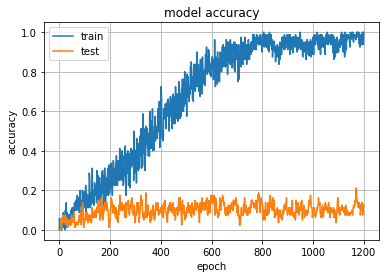

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

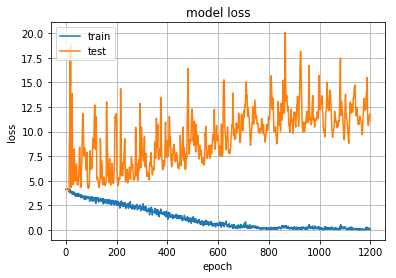

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_6_0_msrgb.jpg is: impoverished_settlement
file airport_45_3_msrgb.jpg is: space_facility
file airport_26_1_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport


In [19]:
loadedModel = load_model("DenseNet161Model.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_30_6_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: airport
file airport_299_2_msrgb.jpg is: impoverished_settlement
file airport_118_5_msrgb.jpg is: airport
file airport_7_8_msrgb.jpg is: impoverished_settlement
file airport_319_0_msrgb.jpg is: tunnel_opening
file airport_40_5_msrgb.jpg is: airport
file airport_139_1_msrgb.jpg is: airport
file airport_166_8_msrgb.jpg is: airport
file airport_312_0_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_118_2_msrgb.jpg is: airport
file airport_431_0_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: impoverished_settlement
file airport_199_7_ms